# ASAP 2.0 analyses with hyper-parameters

Purpose

    - Use hyperparameter search findings on a subset of the ASAP 2.0 dataset 
    - Develop LLM scoring models for the subset ASAP 2.0 data using a Fine-tuned transformer based on hyperparameters.
    - This only uses the training and test set. No need for dev set because already tuned for hyperparameters.


## Dataset is ASAP 2.0.

https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/data

This is only looking at the Indiana Data

~12,000 source-based essays of the original 25,000 essays

Scored from 1-6

Training and test sets defined

A variety of demographic information available including

  - economic disadvantage
  - disability (both gifted and challenged)
  - ELL
  - Race
  - Gender
  - Grade

## Install Packages

If you use the hugging_face environment, you will not need to install packages

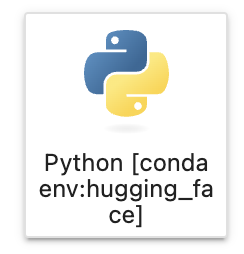

This was set up using this [link](https://github.com/learlab/development-server/wiki/Using-JupyterHub#virtual-environments-in-python)

In [ ]:

#!pip install transformers[torch]
#!pip install --quiet transformers[torch] #datasets evaluate pingouin


## Import packages

In [ ]:
#install transformers and other packages that might not exist
#!pip install transformers
#!pip install datasets
#!pip install evaluate
#!pip install transformers[sentencepiece]

In [ ]:
#had some problems and needed to upgrade some stuff

#!pip install --upgrade pyarrow
#!pip uninstall -y datasets
#!pip install datasets

In [1]:
#!pip install scikit-learn


#import libraries that are not problematic

import pandas as pd # You know what this is
import sklearn
import numpy as np # Numpy is for whenever you have numbers in Python
import seaborn as sns # Plotting library based on MatPlotLib
from scipy import stats # Statistical distributions, functions, and a few tests
from IPython.display import display # print(), but for HTML output (like Pandas dataframes)

In [2]:
# The following packages and modules are all from HuggingFace

# A class for managing data with lots of useful features for model training
#!pip install --upgrade datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# The following packages and modules are all from HuggingFace

# We import four classes from transformers.
from transformers import (
    # All language models start with tokens (by definition)
    AutoTokenizer,
    # Convenience class for creating and using transformer-based sequence classifiers
    AutoModelForSequenceClassification,
    # Configuration class for managing, you guessed it, training arguments
    TrainingArguments,
    # A class that abstracts away the PyTorch training loop.
    Trainer,
    # A data collator organizes (collates) the data into batches for training
    # It will also add special [PAD] tokens to make all the sequences in a batch the same length
    # Batches with equal-length sequences make our GPU go brr
    DataCollatorWithPadding,
    DefaultDataCollator
)

# A library for performance evaluations metrics
# Especially useful for complex and task-specific metrics
# For example, the GLUE metric can score language models on a suite of popular benchmarks
# But we will just use some simple metrics today
import evaluate

# Pipelines are used to streamline tokenization and inference
# We will create a pipeline after finetuning!
from transformers import pipeline





## Load and Prepare ASAP Corpus

In [8]:
asap_df = (
    pd.read_csv("data/ASAP2_new_IN_data_only_w_splits.csv"))


asap_df

,essay_id,score,full_text,set,pubpriv,assignment,prompt_name,economically_disadvantaged,student_disability_status,ell_status,race_ethnicity,gender,grade_level,essay_word_count,source,task,stratified_split
0,AAAOPP13416000019936,4,"Being a Seagoing Cowboy is really fun, but als...",test,private,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Economically disadvantaged,Not identified as having disability,No,Black/African American,M,6,538.0,MI,Text dependent,train
1,AAAOPP13416000055926,5,"To whom ever reads this at the end, you might ...",test,public,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Hispanic/Latino,F,6,367.0,MI,Text dependent,train
2,AAAOPP13416000005911,3,Have you ever wondered about what you might do...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Economically disadvantaged,Not identified as having disability,No,Two or more races/Other,F,6,498.0,MI,Text dependent,train
3,AAAOPP13416000019800,3,I believe that you should join the Seagoing Co...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Asian/Pacific Islander,F,6,317.0,MI,Text dependent,train
4,AAAOPP13416000019823,4,Would you like to participate in the Seagoing ...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Asian/Pacific Islander,F,6,443.0,MI,Text dependent,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11821,AAAOPP13416000218424,1,We've been discovering things almost everyday....,test,private,You have read the article 'Unmasking the Face ...,The Face on Mars,Economically disadvantaged,Not identified as having disability,No,Black/African American,M,8,259.0,MI,Text dependent,train
11822,AAAOPP13416000254175,1,In 1976 the queation was and everyone was also...,train,0,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Two or more races/Other,M,8,226.0,MI,Text dependent,test
11823,AAAOPP13416000260386,1,25 years ago there was a face discovered by na...,test,private,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Black/African American,M,8,163.0,MI,Text dependent,train
11824,AAAOPP13416000292300,1,The\n\nfirst thing that i should include in my...,train,0,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Black/African American,F,8,292.0,MI,Text dependent,dev


### Basic descriptives

In [9]:
print(asap_df.shape)

print(asap_df['stratified_split'].unique())
print(asap_df['stratified_split'].value_counts())

(11826, 17)
['train' 'test' 'dev']
stratified_split
train    5913
test     2957
dev      2956
Name: count, dtype: int64


In [10]:
#number of words

mean_nw = asap_df['essay_word_count'].mean()
sd_nw = asap_df['essay_word_count'].std()
max_nw = asap_df['essay_word_count'].max()

print(f'mean number of words = {mean_nw}')
print(f'sd for number of words = {sd_nw}')
print(f'max for number of words = {max_nw}')


#how many essays are greated than 512 words? (almost 1,400)

llm_max = 512

llm_over = (asap_df['essay_word_count'] > llm_max).sum()
print(f'essays that are over 512 word = {llm_over}')


mean number of words = 345.252600422833
sd for number of words = 137.23794146671835
max for number of words = 1213.0
essays that are over 512 word = 1386


In [11]:
#statistics on the data itself

prompt_count = asap_df['prompt_name'].value_counts()
ed_count = asap_df['economically_disadvantaged'].value_counts()
sd_count = asap_df['student_disability_status'].value_counts()
ell_count = asap_df['ell_status'].value_counts()
re_count = asap_df['race_ethnicity'].value_counts()
gen_count = asap_df['gender'].value_counts()
grade_count = asap_df['grade_level'].value_counts()

print(prompt_count)
print("\n")
print(ed_count)
print("\n")
print(sd_count)
print("\n")
print(ell_count)
print("\n")
print(re_count)
print("\n")
print(gen_count)
print("\n")
print(grade_count)

prompt_name
Driverless cars                  4280
Facial action coding system      2710
Exploring Venus                  2611
The Face on Mars                 1423
"A Cowboy Who Rode the Waves"     802
Name: count, dtype: int64


economically_disadvantaged
Economically disadvantaged        7843
Not economically disadvantaged    3982
Name: count, dtype: int64


student_disability_status
Not identified as having disability    10292
Identified as having disability         1533
Name: count, dtype: int64


ell_status
No     9447
Yes    2069
Name: count, dtype: int64


race_ethnicity
White                             3887
Hispanic/Latino                   3641
Black/African American            2354
Two or more races/Other           1018
Asian/Pacific Islander             866
American Indian/Alaskan Native      55
Name: count, dtype: int64


gender
M    6203
F    5622
Name: count, dtype: int64


grade_level
10    9601
8     1423
6      802
Name: count, dtype: int64


In [12]:
#get columns you want and rename them using correct conventions
asap_df2 = asap_df[['full_text', 'score', 'stratified_split']].rename(
    columns={
        'full_text': 'text',
        'score': 'label'})

asap_df2


,text,label,stratified_split
0,"Being a Seagoing Cowboy is really fun, but als...",4,train
1,"To whom ever reads this at the end, you might ...",5,train
2,Have you ever wondered about what you might do...,3,train
3,I believe that you should join the Seagoing Co...,3,train
4,Would you like to participate in the Seagoing ...,4,test
...,...,...,...
11821,We've been discovering things almost everyday....,1,train
11822,In 1976 the queation was and everyone was also...,1,test
11823,25 years ago there was a face discovered by na...,1,train
11824,The\n\nfirst thing that i should include in my...,1,dev


In [13]:
print(asap_df2.dtypes)

#label is a int64, but it needs to be float64 for the transformer to work

asap_df2['label'] = asap_df2['label'].astype('float64')

print(asap_df2.dtypes)

text                object
label                int64
stratified_split    object
dtype: object
text                 object
label               float64
stratified_split     object
dtype: object


### Get training and test sets

These are already defined in the datasets. Just need to divide and name them

This is with a validation set used for hyperparameters

Training and test sets would be different and found underset.



In [14]:
# Don't use entirety of "test" - just use the private "test"
# For training, only use "train" for training; don't use public "test" because it was used for hyperparamter tuning

asap_dd = datasets.DatasetDict({
   "train": datasets.Dataset.from_pandas(asap_df2[asap_df2["stratified_split"] == "train"]),
   "test": datasets.Dataset.from_pandas(asap_df2[asap_df2["stratified_split"] == "test"])
})

In [15]:
#! View the structure of the train set
#! display() the first (0th) example

display(asap_dd["train"]) #features
display(asap_dd["test"]) #features
display(asap_dd["train"][0]) #text

Dataset({
    features: ['text', 'label', 'stratified_split', '__index_level_0__'],
    num_rows: 5913
})

Dataset({
    features: ['text', 'label', 'stratified_split', '__index_level_0__'],
    num_rows: 2957
})

{'text': "Being a Seagoing Cowboy is really fun, but also can be a challenge. You travel around the world and you get to see really cool things. But its not all fun, you have to help and work.\n\nI loved being a Seagoing Cowboy, it changed my life. I was on the SS Charles W. Wooster, headed for Grecce, with 335 horsess and lots of hay and oats. I made nine trips. More trips than any Seagoing Cowboy. Being a Seagoing Cowboy is a great opportunity to help people in need, travel, learn, and to meet new people. You can go to Venice, Italy and take a gondola ride, or tour a excavated castle in Crete. Also, go to the Panama Canal or see the Acropolis in Greece. There are many things to do while being a Seagoing Cowboy.\n\nEveryone likes a little fun once in a while, but you don't always get to have fun. When being a Seagoing Cowboy, there are lots of dangerous things that can happen. You can slip off deck and drown. You can get badly injuired. Also, you can get sea sick. I cracked my ribs wh

In [16]:
#! Find the lowest scored essay in the training set.

# Loop
min_writing = 1 #change this number to see various scores
for sample in asap_dd["train"]:
  if sample["label"] == min_writing:
    min_writing = sample["label"]
    min_sample = sample
display(min_sample)


{'text': "25 years ago there was a face discovered by nasa's viking 1 and viking 2 spacecraft. it was nearly 2 miles long. A person named Xavier Smith believes the face on planet mars was created by aliens. I told him the face is just a natural form land. The reason it is a natural land form is because there are lots of strange things that happen like that on different planets. Some scientist believe the face was an alien artifact. It could have just formed there. In my opinion i don't believe aliens are real. I believe that the humans are the only race. If aliens were real they would have probly tooken over planet earth right now. There are a lot of people who think aliens are real. People think they fly around in invisible ufo's and have really advanced technology. What the picture actually shows is the martain equivalent of a butte or mesa-landforms common around the american west. That is my discussion on the face on planet mars.",
 'label': 1.0,
 'stratified_split': 'train',
 '__i

In [17]:
# Training regression-type models requires a floating point response variable
# The Type is "Value", which comes from the datasets library
asap_dd["train"].features['label']

Value(dtype='float64', id=None)

### Pre-process inputs (tokenization)

This is for train, dev, and test sets as set up.

`transformers` will handle tokenization, but it's worth looking at what it does.  Huggingface toenization course [here](https://huggingface.co/course/chapter2/4?fw=pt).

Different models require different types of tokenization. You need to choose a model before you tokenize. 

This will use [roberta-large](https://huggingface.co/microsoft/deberta-v3-large) from huggingface. 

Want to run deberta-v3-large, but having problems (microsoft/deberta-v3-large)

In [18]:
# Instantiate tokenizer by downloading tokenizer config files from HF Hub
#tokenizer = AutoTokenizer.from_pretrained('roberta-large') #roberta works
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large') #deberta requires transformers[sentencepiece] or 
#tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large", use_fast=False) 
#transformers now uses fast tokenizers by default, but the deberta tokenizer is a slow tokenizer
tokenizer.name_or_path #what tokenizer are we using?

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


'microsoft/deberta-v3-large'

In [19]:
# Define tokenizing function
# Models usually have a max length (the number of tokens they can process per sample)
# roberta-large max length is 512 tokens, which is about 300-400 words.
# Many essays will be longer (around 4K)

def tokenize_inputs(example):
    # This will automatically truncate documents over 512 tokens
    # Truncation is a limitation.
    # If you truncate, clearly describe how many texts are truncated, by how much.
    #max_length=512 cuts essays to 512 words
    return tokenizer(example['text'], truncation=True, max_length=512)

In [20]:
# Do the tokenizing using DataDict.map()
# We remove "text" because it is not used by the transformer.
# Transformers operate on token_ids
asap_dd_tokenized = asap_dd.map(tokenize_inputs, batched=True, remove_columns=['text'])

Map: 100%|██████████| 2957/2957 [00:01<00:00, 2505.37 examples/s]


In [21]:
#what's in the data

asap_dd_tokenized

DatasetDict({
    train: Dataset({
        features: ['label', 'stratified_split', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5913
    })
    test: Dataset({
        features: ['label', 'stratified_split', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2957
    })
})

After tokenization, text samples are transformed as follows:

The **text** field is replaced with two new fields:

*   **input_ids**

The `input_ids` field contains the tokenized input sequences represented as token IDs.

*   **attention_mask**

The `attention_mask` field contains attention masks, which indicate which tokens should be attended to and which should be ignored during model training. In this case, the attention mask is all 1s, indicating that every token is attended to.

In [22]:
#! Grab the 0th item in the train portion of our tokenized dataset and iterate over its .items()
#! print() key and value from inside this loop to see what the tokenized inputs look like.

for key, value in asap_dd_tokenized["train"][0].items():
  print(key, value)

label 4.0
stratified_split train
__index_level_0__ 0
input_ids [1, 3555, 266, 3284, 11186, 30226, 269, 431, 785, 261, 304, 327, 295, 282, 266, 1719, 260, 367, 1248, 441, 262, 447, 263, 274, 350, 264, 398, 431, 1570, 479, 260, 420, 359, 298, 305, 785, 261, 274, 286, 264, 408, 263, 374, 260, 273, 1520, 411, 266, 3284, 11186, 30226, 261, 278, 1594, 312, 432, 260, 273, 284, 277, 262, 9937, 3519, 1462, 260, 76543, 261, 3763, 270, 100679, 6074, 261, 275, 32775, 5395, 268, 263, 1738, 265, 12530, 263, 21591, 260, 273, 412, 2639, 4541, 260, 1366, 4541, 354, 356, 3284, 11186, 30226, 260, 3555, 266, 3284, 11186, 30226, 269, 266, 426, 1062, 264, 408, 355, 267, 389, 261, 1248, 261, 799, 261, 263, 264, 957, 353, 355, 260, 367, 295, 424, 264, 12319, 261, 3479, 263, 413, 266, 47882, 2224, 261, 289, 1845, 266, 40156, 8444, 267, 34563, 260, 1184, 261, 424, 264, 262, 13560, 13497, 289, 398, 262, 74067, 267, 6791, 260, 443, 281, 386, 479, 264, 333, 438, 411, 266, 3284, 11186, 30226, 260, 4042, 5806, 266, 

In [23]:
#what is the max length of the input ids (i.e., did they truncate)

max_length = max([len(n['input_ids']) for n in asap_dd_tokenized['train']] +
                 [len(n['input_ids']) for n in asap_dd_tokenized['test']])

print(max_length) # they are at 512, so truncation worked

512


### Data Collator
A data collator feeds the data to the language model. There are some interesting optimizations that can be made [here](https://huggingface.co/course/chapter3/2?fw=pt).




In [24]:
# Instantiate data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#This data collator is used to dynamically pad input sequences to the maximum length within each batch during training
#ensures that all sequences within a batch have the same length by adding padding tokens to the shorter sequences
#DataCollatorWithPadding handles variable-length input sequences and avoids the need for manual padding or truncation


## USE HYPERPARAMETER TUNING

**it is only based on a training and test set**

Hyperparameter tuning was done in 

active-projects/asap_scoring/asap_llm_hyper_search_final.ipynb

The results are below.

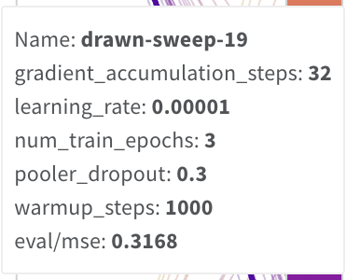


## Set up Training



### Define model and task


### `AutoModelForSequenceClassification.from_pretrained()`

1.   Downloads the model you specify from the HuggingFace Hub. Downloading a model means downloading the pretrained model weights, as well as some configuration files. The model architecture is already described inside the `transformers` library.
2.   Discards the language modeling head of the model.
3.   Creates a brand new sequence classification head with randomly initialized weights -- you will see some warnings about this to remind you that you need to train the model!

### `model_init`
We use a `model_init()` function here instead of loading the model directly. This way, we will get a fresh distilbert everytime we rerun later code cells. This allows us to start training from the Huggingface checkpoint on every training run. In other words, we guarantee that training will always start from the Hugginface weights. This prevents us from accidentally resuming training when we don't mean to!


In [25]:
# Define a model init function, which will help us start training from scratch
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(
      'microsoft/deberta-v3-large',
      #'roberta-large', # the name of the model on HuggingFace Hub
      num_labels=1, # Regression is just classification with a single, continous label. So intuitive!
      pooler_dropout=0.3, 
      # Add pooler dropout, which applies dropout to the pooling layer to help prevent overfitting by randomly dropping out units during training.
      # This is from hyperparameter tuning    
      )

### Define Metrics

Let's consider what metrics might be useful for training this model. Lots of metrics are available to us through [HF Datasets Metrics repo](https://huggingface.co/metrics).

In [26]:
# Load some useful performance metrics using evaluate library
# These metrics are complementary. They tell us different things about model performance.
metrics = evaluate.combine(
    #combine multiple evaluation metrics into a single evaluation object 
    {
        # Root Mean Squared Error (RMSE); lower is better; more sensitive to few big errors
        "RMSE" : evaluate.load("mse", squared=False),
        # Mean Absolute Error; lower is better; less sensitive to few big errors
        "MAE": evaluate.load('mae')
    }
)

# Define compute_metrics()
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Alternative option is to use sklearn metrics here
    return metrics.compute(predictions=logits, references=labels) #logits refer to the raw, unnormalized outputs of the final layer of model
                                                                  #labels are the true values being predicted.

Using the latest cached version of the module from /home/jovyan/project-archive/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mse/5303f8acce26cdffcedb23101b42d1660bf34c3d8885adcd0bb262916312a51a (last modified on Wed Jul 10 14:28:57 2024) since it couldn't be found locally at evaluate-metric--mse, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /home/jovyan/project-archive/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mae/5fe238d4687034334f553827fa1d2c7402dccf2c453c64ff42a63b484fa42b0b (last modified on Wed Jul 10 14:28:57 2024) since it couldn't be found locally at evaluate-metric--mae, or remotely on the Hugging Face Hub.


In [27]:
for metric in metrics.evaluation_modules:
  print(f"{metric.name:_^80}") #spacer
  print(metric.description) #description of metric if curious

______________________________________mse_______________________________________
Mean Squared Error(MSE) is the average of the square of difference between the predicted
and actual values.

______________________________________mae_______________________________________
Mean Absolute Error (MAE) is the mean of the magnitude of difference between the predicted and actual
values.



### Model Training


In [28]:
#will need to know where to store output
import os

current_directory = os.getcwd()
print(current_directory)


/home/jovyan/active-projects/asap_scoring


In [29]:

training_args = TrainingArguments(
    # directory to save model checkpoints
    output_dir="/home/jovyan/active-projects/asap_scoring/hyper_parameter_model",
    # how often to log. 'epoch' means that logging will happen at the end of every epoch
    logging_strategy='epoch',
    # how often to evaluate performance
    eval_strategy='epoch',
    # how often to save a model checkpoint
    save_strategy='no',
    # If an earlier checkpoint was better than the last one, load that checkpoint from disk
    # We cannot do this, because we don't have a development set
    load_best_model_at_end=False,
    # Not used; how to choose which model was best
    metric_for_best_model=None,
    # Not used; but lower RMSE is better
    greater_is_better=False,
    per_device_train_batch_size= 2, # 8 or 16 are typical. Switch to 2 to avoid OutOfMemoryError!
    per_device_eval_batch_size= 2, # 8 or 16 are typical. Switch to 2 to avoid OutOfMemoryError!
    #! Try 1e-5, 5e-5, or 1e-4.
    learning_rate= 0.00001,
    #! Try 2, 3, or 4 epochs
    num_train_epochs=3,# Add gradient accumulation steps
    #add gradient accumulation which helps to stabilize the training by effectively increasing the batch size
    gradient_accumulation_steps=32,
    # Add warmup steps, which gradually increase the learning rate to  stabilize training during the initial steps.
    warmup_steps=1000,
    report_to= "none", #this should stop wandb from firing, which saves a lot of heartache
)

In [30]:

# We defined all these components in the code above and saved them as variables
# Add those variables as arguments to the Trainer call to make our trainer :)
trainer = Trainer(
    # notice that this is "model_init" and NOT "model_init()"
    # if we add the (), it will evaluate the function and provide the func output to the trainer
    # but we want to give the function itself to the trainer
    # functions are just objects, and we can pass them around by name
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    train_dataset=asap_dd_tokenized["train"], #! the training dataset
    eval_dataset=asap_dd_tokenized["test"], #! the testing set 
    compute_metrics=compute_metrics,
)



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Finetune the model
finetune the model!


In [31]:


trainer.train()

trainer.save_model(
    output_dir="/home/jovyan/active-projects/asap_scoring/hyper_parameter_subset_asap_model"
)
#this will save the model trained on the training data. We can use that later to test the training model on the test set.

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae
0,7.337500,5.759406,5.759406,2.180303
1,1.474200,0.402250,0.402250,0.490630
2,0.438200,0.355156,0.355156,0.462006


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Results from Hyperparameter model**


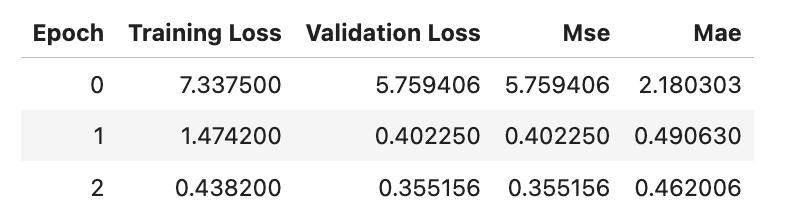


In [32]:
#evaluates on test set
trainer.evaluate(
    asap_dd_tokenized["test"]
    )

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'eval_loss': 0.35515642166137695,
 'eval_mse': 0.3551563722430037,
 'eval_mae': 0.4620055237613016,
 'eval_runtime': 106.137,
 'eval_samples_per_second': 27.86,
 'eval_steps_per_second': 13.935,
 'epoch': 2.9868109570510653}

{'eval_loss': 0.35515642166137695,
 'eval_mse': 0.3551563722430037,
 'eval_mae': 0.4620055237613016,
 'eval_runtime': 106.137,
 'eval_samples_per_second': 27.86,
 'eval_steps_per_second': 13.935,
 'epoch': 2.9868109570510653}

Here's what each of these components is telling us:

epoch: the epoch number at which the evaluation is performed.

eval_loss: the evaluation loss. The evaluation loss is a measure of how well the model performs on the evaluation dataset, with lower values indicating better performance.

eval_mse: Why is this the same as eval_loss? Because mean-squared error was our loss function!

eval_mae: Mean Absolute Error

eval_runtime: the total runtime of the evaluation process in seconds.

eval_samples_per_second: the number of samples processed per second.

eval_steps_per_second: the number of batches processed per second.

In [33]:
#Generate predictions using the trained model on a given datase

pred = trainer.predict(
    asap_dd_tokenized["test"]
)

print(pred.predictions)#the predicitions
print(pred.metrics)#the metrics

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[4.406644  4.1744814 3.0000076 ... 2.366645  2.2530289 2.066444 ]
{'test_loss': 0.35515642166137695, 'test_mse': 0.3551563722430037, 'test_mae': 0.4620055237613016, 'test_runtime': 106.7334, 'test_samples_per_second': 27.705, 'test_steps_per_second': 13.857}


Results for metrics

[1.9069762 4.2317324 2.5674455 ... 2.4829235 3.4350843 2.231167 ]
{'test_loss': 0.3599712550640106, 'test_mse': 0.35997127510555743, 'test_mae': 0.46479457808408875, 'test_runtime': 197.4437, 'test_samples_per_second': 26.154, 'test_steps_per_second': 13.077}

In [34]:
# .reshape(-1) removes an empty dimension
# We get a one-dimensional array (similar to a list)
pred.predictions.reshape(-1)

array([4.406644 , 4.1744814, 3.0000076, ..., 2.366645 , 2.2530289,
       2.066444 ], dtype=float32)

In [35]:
# Create a dataframe for inspection
preds_df = pd.DataFrame(
    {
        'predicted':pred.predictions.reshape(-1), # flatten array
        'true':pred.label_ids,
        'text':asap_dd['test']['text'] #! Add the text column of the test partition here
    }
)
display(preds_df.sample(2)) # .sample(2) randomly selects 2 rows

,predicted,true,text
1084,2.650570,2.0,"In the story ""Driverless Cars Are Coming,"" wit..."
2407,2.394674,2.0,People will have differant oppions on this Fac...


In [36]:
preds_df.shape

(2957, 3)

In [37]:
#save dataframe for later use

preds_df.to_csv('hyper_parameterized_test_results_asap_subset_in.csv', index=False)

R-squared: 0.670, P-value= 0.000


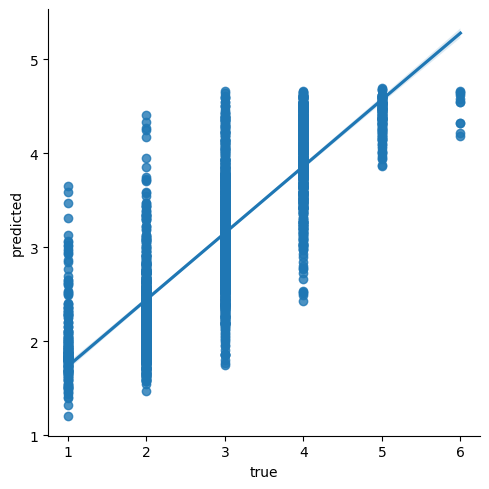

In [38]:
# Run the simple linear regression
results = stats.linregress(preds_df["true"], preds_df["predicted"])

# Using an f-string to clearly display and round the relevant output
print(f"R-squared: {results.rvalue**2:.3f}, P-value= {results.pvalue:.3f}")

# Plot the data with a regression line
sns.lmplot(x='true', y='predicted', data=preds_df);

0.6723999999999999

### Calling in saved model

This is the easiest solution if you return to this notebook long after it has been run.

It will allow you to retrieve saved model as needed without retraining the model using all the steps above




In [5]:
#call in the saved model

#The chunk above saved three items
# 1. Config.json: Configuration settings for transformer model like the model architecture
# 2. model.safetensors: weights and parameters of the trained transformer model
# 3. training_args.bin: the arguments and settings that were used during the training process of the transformer model
# learning rate, batch size, etc...

# call in a new variable called trainer_saved and use it below for trainer_saved.evaluate and trainer_saved.predict

#set path
PATH = "/home/jovyan/active-projects/asap_scoring/hyper_parameter_model"

num_labels = 1 #for regression analysis. This would change with classification
model = AutoModelForSequenceClassification.from_pretrained(PATH, num_labels=num_labels)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element